In [1]:
import tifffile as tiff
import matplotlib.pyplot as plt

In [2]:
# import dash
# import dash_core_components as dcc
# import dash_html_components as html
# from dash.dependencies import Input, Output
import numpy as np

In [3]:
import numpy as np
import tifffile as tiff
import sys

def get_specific_frame(red_tiff_path:str,idx:int):
    """
    get specific frame
    """
    with tiff.TiffFile(red_tiff_path) as red_img:
        frame = red_img.pages[idx].asarray()
        max_len = len(red_img.pages)
    return frame,max_len

def read_tiff_series(video_path, max_frames=None):
    """
    Reading the tiff files up to a defined frame number.
    """
    with tiff.TiffFile(video_path) as tif:
        # Determine the total number of frames to read
        total_frames = len(tif.pages)
        if max_frames is not None:
            total_frames = min(total_frames, max_frames)
        
        # Initialize the image array based on the shape of the first frame
        first_frame = tif.pages[0].asarray()
        shape = (total_frames,) + first_frame.shape
        img_array = np.empty(shape, dtype=first_frame.dtype)
        
        # Read frames up to the total_frames
        for i in range(total_frames):
            img_array[i] = tif.pages[i].asarray()
            update_progress(i / total_frames, "Loading")
    return img_array

def update_progress(progress, added_text="Progress"):
    """
    Updates the progress bar.
    """
    diff = round(progress, 3) - round(progress, 2)
    if diff != 0:
        return None
    barLength = 30  # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "Error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength * progress))
    text = "\r" + added_text + ": [{0}] {1}% {2}".format("#" * block + "-" * (barLength - block), progress * 100, status)
    sys.stdout.write(text)
    sys.stdout.flush()


In [4]:
btf_path = '/lisc/scratch/neurobiology/zimmer/schaar/Behavior/test_new_pipeline/2024-02-06_12-11-45_cam4_1per_AVE_ctrl_R2/2024-02-06_12-11-45_cam4_1per_AVE_ctrl_R2_track_0/track.tif'

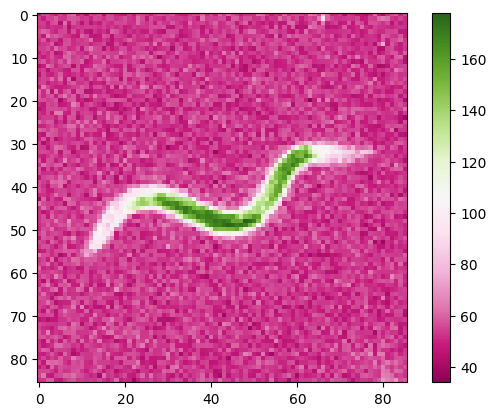

In [5]:
import matplotlib.pyplot as plt

specific_frame = 7

frame, max_len = get_specific_frame(btf_path, specific_frame)

#invert 
frame = 255 - frame

plt.imshow(frame, cmap='PiYG')
plt.colorbar()  # Add colorbar legend
plt.show()


In [6]:
#worm_video = read_tiff_series(btf_path)

worm_video = read_tiff_series(btf_path, max_frames=specific_frame+1)

Loading: [######################--------] 75.0% 

worm_video.shape

In [7]:
import cv2
def draw_some_contours(img, contour_size, tolerance, inner_contour_area_to_fill):
    """
    Return img with drawn contours based on size, filling contours below inner_contour_area_to_fill
    Parameters:
    -----------
    img, numpy array
    image from where the contours will be taken
    contour_size, float
        expected area of the contour to be extracted
    tolerance, float
        tolerance around which other contours will be accepted. e.g. contour_size 100 and tolerance 0.1 will include contours from 90 to 110.
    inner_contour_area_to_fill, float
        area of inner contours that will be filled

    Returns:
    -----------
    img_contours, numpy array
        image with drawn contours
    """

    # convert image dtype if not uint8
    # image has to be transformed to uint8 for the findContours
    img = img.astype(np.uint8)
    # get contours
    cnts, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # good contours index
    cnts_idx = []  # np.array([])
    # create empty image
    img_contours = np.zeros(img.shape)

    for cnt_idx, cnt in enumerate(cnts):
        cnt_area = cv2.contourArea(cnt)
        # if the contour area is between the expected values with tolerance, save contour in cnts_idx and draw it
        if (contour_size * (1 - tolerance) < cnt_area < contour_size * (1 + tolerance)):
            cnts_idx.append(np.array(cnt_idx))
            #print("found it!")
            cv2.drawContours(img_contours, cnts, cnt_idx, color=255, thickness=-1, hierarchy=hierarchy, maxLevel=1)
        else:
#             print(f"contour was {cnt_area} which is no in the range min f{contour_size * (1 - tolerance)} max {contour_size * (1 + tolerance)}")
        # if the current cnt_idx has as a parent a contour in good countours (cnts_idx)
            if hierarchy[0][cnt_idx][3] in cnts_idx:
            # (and) if it is smaller than inner contour, draw it
                if cnt_area < inner_contour_area_to_fill:
                # print(cv2.contourArea(contours[j]))
                    cv2.drawContours(img_contours, cnts, cnt_idx, color=255, thickness=-1)

    # convert the resulting image into a 8 binary numpy array
    img_contours = np.array(img_contours, dtype=np.uint8)

    return img_contours

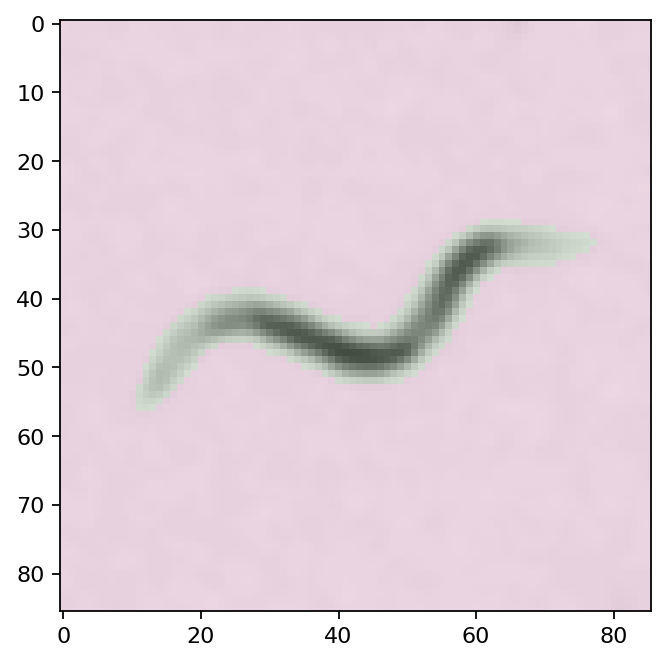

In [13]:
from scipy import ndimage

threshold = 63
max_value = 255

blur_gaussian = 5 #needs to be odd
blur_median = 1
contour_size = 400 #23000
tolerance = 0.5
inner_contour_to_fill = 50 #2400

#erode mask
iterations = 0



blurred_frame = cv2.GaussianBlur(frame, (blur_gaussian, blur_gaussian), 0)
blurred_frame = cv2.medianBlur(blurred_frame, blur_median)
    
    
# apply threshold
ret, new_img = cv2.threshold(blurred_frame, threshold, max_value, cv2.THRESH_BINARY)
# draw_some_contours does not need imfunctions.draw_some_contours in here. But outside this file.
worm_contour_img = draw_some_contours(img=new_img, contour_size=contour_size, tolerance=tolerance,inner_contour_area_to_fill=inner_contour_to_fill)
# fig = plt.figure(dpi=300)
#worm_contour_img = ndimage.binary_erosion(worm_contour_img,iterations=iterations)

#original
plt.figure(dpi=160)
plt.imshow(worm_contour_img,cmap='PiYG',alpha=0.4)
plt.imshow(blurred_frame,cmap='Greys',alpha=0.6)


In [9]:

image_array_stack = read_tiff_series(btf_path, specific_frame)

def binarize_stack(image_array_stack, threshold, max_value, blur_gaussian, blur_median, contour_size, tolerance, inner_contour_to_fill, iterations):
    binarized_stack = []
    for frame in image_array_stack:
        # Apply Gaussian and median blurs
        blurred_frame = cv2.GaussianBlur(frame, (blur_gaussian, blur_gaussian), 0)
        blurred_frame = cv2.medianBlur(blurred_frame, blur_median)
        
        # Apply threshold
        _, new_img = cv2.threshold(blurred_frame, threshold, max_value, cv2.THRESH_BINARY)
        
        # Draw and fill contours
        worm_contour_img = draw_some_contours(img=new_img, contour_size=contour_size, tolerance=tolerance, inner_contour_area_to_fill=inner_contour_to_fill)
        
        # Apply binary erosion
        worm_contour_img = ndimage.binary_erosion(worm_contour_img, iterations=iterations)
        
        # Draw and fill contours again
        worm_contour_img_binarized = draw_some_contours(img=worm_contour_img, contour_size=contour_size, tolerance=tolerance, inner_contour_area_to_fill=inner_contour_to_fill)
        
        # Append the processed image to the list
        binarized_stack.append(worm_contour_img_binarized)
    
    return binarized_stack


binarized_image_array = binarize_stack(image_array_stack, threshold, max_value, blur_gaussian, blur_median, contour_size, tolerance, inner_contour_to_fill, iterations)

import matplotlib.pyplot as plt
from ipywidgets import interact

# Function to display a frame from the image array
def display_frame(frame_index):
    frame = binarized_image_array[frame_index]
    print(frame.shape)  # Add this line to check the shape of the frame
    plt.imshow(frame, cmap='PiYG')  # Or use a different color map if appropriate
    plt.title(f"Frame {frame_index}")
    plt.axis('off')  # Hide the axes
    plt.show()

# Get the number of frames in the image array
num_frames = len(binarized_image_array)

# Create an interactive slider for selecting the frame
interact(display_frame, frame_index=(0, num_frames - 1, 1))


Loading: [------------------------------] 0.0% 

interactive(children=(IntSlider(value=3, description='frame_index', max=6), Output()), _dom_classes=('widget-i…

<function __main__.display_frame(frame_index)>